<a href="https://colab.research.google.com/github/satya748/Codtech-projects/blob/main/Neural_style_transfer_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import copy


In [ ]:
from google.colab import files
import os

# Upload images (first = content, second = style)
print("📥 Upload your content image first, then your style image.")
uploaded = files.upload()

# Convert uploaded files into a list
uploaded_filenames = list(uploaded.keys())

# Rename files automatically
if len(uploaded_filenames) == 2:
    os.rename(uploaded_filenames[0], "content.jpg")
    os.rename(uploaded_filenames[1], "style.jpg")
    print(f"\n✅ '{uploaded_filenames[0]}' → content.jpg")
    print(f"✅ '{uploaded_filenames[1]}' → style.jpg")
elif len(uploaded_filenames) == 1:
    os.rename(uploaded_filenames[0], "content.jpg")
    print(f"\n✅ '{uploaded_filenames[0]}' → content.jpg")
    print("🟡 Now run this cell again and upload your style image.")
else:
    print("⚠️ Please upload one or two images.")


📥 Upload your content image first, then your style image.


Saving download.jpg to download.jpg
Saving unnamed.jpg to unnamed.jpg

✅ 'download.jpg' → content.jpg
✅ 'unnamed.jpg' → style.jpg


In [ ]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        # Change to directly access width and height from shape
        size = (shape[0], shape[1]) # or size = tuple(shape)

    in_transform = transforms.Compose([
        transforms.Resize(size), # Pass size as a tuple
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ])

    image = in_transform(image).unsqueeze(0)
    return image

In [ ]:
content = load_image("content.jpg")
style = load_image("style.jpg", shape=[content.size(2), content.size(3)])


In [ ]:
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
content = content.to(device)
style = style.to(device)


In [ ]:
def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',  # content layer
        '28': 'conv5_1'
    }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features


In [ ]:
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram


In [ ]:
target = content.clone().requires_grad_(True).to(device)


In [ ]:
style_weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.1
}
content_weight = 1e4
style_weight = 1e2

optimizer = torch.optim.Adam([target], lr=0.003)

for i in range(1, 301):
    target_features = get_features(target, vgg)
    content_features = get_features(content, vgg)
    style_features = get_features(style, vgg)

    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = gram_matrix(style_features[layer])
        layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_loss

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if i % 50 == 0:
        print(f"Step {i}, Total Loss: {total_loss.item():.4f}")


Step 50, Total Loss: 2768921088.0000
Step 100, Total Loss: 2050481024.0000
Step 150, Total Loss: 1606052992.0000
Step 200, Total Loss: 1314102144.0000
Step 250, Total Loss: 1115193344.0000
Step 300, Total Loss: 972056704.0000


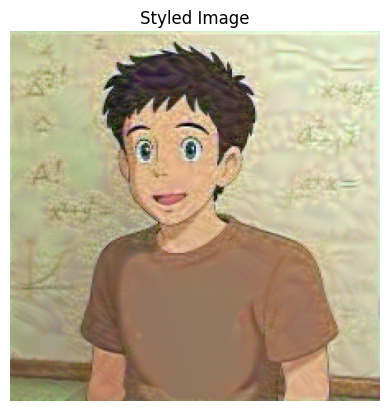

In [ ]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze(0)
    # Reshape the normalization tensors to match the image dimensions for broadcasting
    image = image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    image = image.clamp(0, 1)
    # permute the dimensions to (height, width, channels)
    image = image.permute(1, 2, 0) # Add this line to permute the dimensions
    return image

plt.imshow(im_convert(target))
plt.axis('off')
plt.title("Styled Image")
plt.show()